# 人脸识别 FaceNet_简单模型

In [3]:
# 引入库
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import os
import random

在命令行中切换到想要的虚拟环境（环境名pytorch）
conda activate pytorch\
安装torchsummary指令
pip install torchsummary

In [4]:
torch.cuda.is_available()

True

训练集数量 11184
测试集数量 2049
锚定人脸


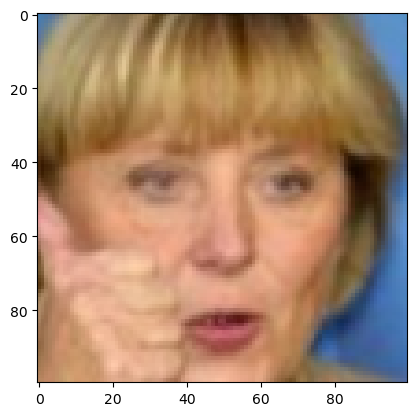

相同人脸


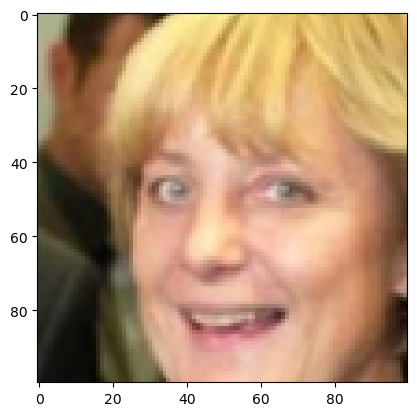

不同人脸


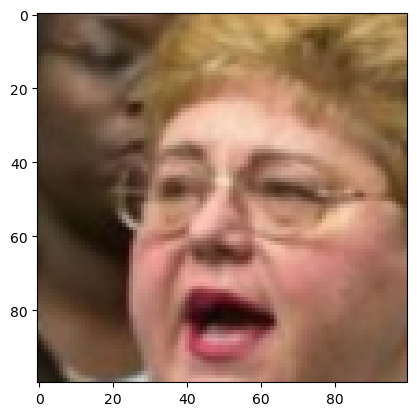

In [5]:
# 导入数据集

# 加载训练数据集
# train_dataset = torchvision.datasets.LFWPeople("../dataset", split="train", transform=torchvision.transforms.ToTensor(), download=True)
# 加载测试数据集
# test_dataset = torchvision.datasets.LFWPeople("../dataset", split="test", transform=torchvision.transforms.ToTensor(), download=True)

#自定义Dataset类，__getitem__(self,index)每次返回(img1, img2, 0/1)
class SiameseNetworkDataset(Dataset):

    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        # 统计每一个人脸图像的数目，并记录在数组中
        self.nums = np.zeros(50000)
        for data in self.imageFolderDataset.imgs:
            self.nums[data[1]] += 1
        
    def __getitem__(self,index):
        while True:
            # 从类别中任选一个,直到找到同一类别有两幅及以上图片，作为锚定图片
            data_anc = random.choice(self.imageFolderDataset.imgs)
            if (self.nums[data_anc[1]] > 1):
                break
        while True:
            #直到找到同一类别并且两幅图片不能完全相同
            data_pos = random.choice(self.imageFolderDataset.imgs) 
            if (data_anc[1] == data_pos[1]) & (data_anc[0] != data_pos[0]):
                break
        while True:
            #直到找到非同一类别
            data_neg = random.choice(self.imageFolderDataset.imgs) 
            if data_anc[1] != data_neg[1]:
                break

        img_anc = Image.open(data_anc[0])
        img_pos = Image.open(data_pos[0])
        img_neg = Image.open(data_neg[0])
        
        if self.transform is not None:
            img_anc = self.transform(img_anc)
            img_pos = self.transform(img_pos)
            img_neg = self.transform(img_neg)

        return img_anc, img_pos, img_neg
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    

#定义文件dataset
# 数据集根目录
train_root = r"dataset/train_LFW_cropped"
test_root = r"dataset/test_LFW_cropped"

train_folder_dataset = torchvision.datasets.ImageFolder(root=train_root)
test_folder_dataset = torchvision.datasets.ImageFolder(root=test_root)

# 定义transform用于数据预处理
# 进行裁剪
transform_train_0 = torchvision.transforms.Compose([torchvision.transforms.Resize([100, 100]),
                                                    torchvision.transforms.ToTensor()])
# 进行裁剪，随机旋转
transform_train_1 = torchvision.transforms.Compose([torchvision.transforms.Resize([100, 100]),
                                                    torchvision.transforms.RandomRotation(20),
                                                    torchvision.transforms.ToTensor()])
# 进行裁剪，水平翻转
transform_train_2 = torchvision.transforms.Compose([torchvision.transforms.Resize([100, 100]),
                                                    torchvision.transforms.RandomHorizontalFlip(p=1),
                                                    torchvision.transforms.ToTensor()])
# 进行裁剪，改变亮度对比度等等
transform_train_3 = torchvision.transforms.Compose([torchvision.transforms.Resize([100, 100]),
                                                    torchvision.transforms.ColorJitter(brightness=1, contrast=0.5, saturation=0, hue=0),
                                                    torchvision.transforms.ToTensor()])
# 进行裁剪
transform_test = torchvision.transforms.Compose([torchvision.transforms.Resize([100, 100]),
                                                 torchvision.transforms.ToTensor()])

#定义图像dataset
train_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=train_folder_dataset,
                                        transform=transform_train_0,
                                        should_invert=False)
print("训练集数量", len(train_siamese_dataset))

test_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_folder_dataset,
                                        transform=transform_test,
                                        should_invert=False)
print("测试集数量", len(test_siamese_dataset))

#定义图像dataloader
batch_size = 64
train_dataloader = DataLoader(train_siamese_dataset,
                            shuffle=True,
                            batch_size=batch_size)

test_dataloader = DataLoader(test_siamese_dataset,
                            shuffle=True,
                            batch_size=batch_size)

# 输出数据集数据
img_anc, img_pos, img_neg = train_siamese_dataset[2]
print("锚定人脸")
img_anc = torchvision.transforms.ToPILImage()(img_anc)
plt.imshow(img_anc)
plt.show()
print("相同人脸")
img_pos = torchvision.transforms.ToPILImage()(img_pos)
plt.imshow(img_pos)
plt.show()
print("不同人脸")
img_neg = torchvision.transforms.ToPILImage()(img_neg)
plt.imshow(img_neg)
plt.show()

In [6]:
# 定义FaceNet模型
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # # nn.LayerNorm(normalized_shape=[32], eps=0.001),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # # nn.LayerNorm(normalized_shape=64, eps=0.001),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Flatten(),
            nn.Linear(in_features=144, out_features=128),
        )

    def forward(self, input_anc, input_pos, input_neg):
        vector_anc = self.model(input_anc)
        vector_pos = self.model(input_pos)
        vector_neg = self.model(input_neg)
        vector_anc = nn.functional.normalize(vector_anc, p=2)
        vector_pos = nn.functional.normalize(vector_pos, p=2)
        vector_neg = nn.functional.normalize(vector_neg, p=2)
        output_anc, output_pos, output_neg = vector_anc, vector_pos, vector_neg
        return output_anc, output_pos, output_neg # 因为triplet loss输入为3个向量，所以模型内部不求距离

    def Depthwise(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=(1, 1), groups=out_channels, bias=False),
            nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        
    def  Pointwise(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        
    def SepConv(self, in_channels, conv_channels, out_channels, stride=(2, 2)):
        return nn.Sequential(
            self.Depthwise(in_channels, conv_channels, stride),
            self.Pointwise(conv_channels, out_channels)
        )

# 实例化神经网络
model = SiameseNet()
# 使用现有神经网络
# model = torchvision.models.alexnet()

# 将神经网络转换为cuda类型
if torch.cuda.is_available():
    model = model.cuda()
# 打印神经网络信息
print("神经网络信息")
print(model)

# 测试神经网络的输出格式
# 设置满足要求的输入
input_anc = torch.ones([1, 3, 100, 100])
input_pos = torch.zeros([1, 3, 100, 100])
input_neg = torch.randn([1, 3, 100, 100])
print("输入数据1格式", input_anc.shape)
print("输入数据2格式", input_pos.shape)
print("输入数据3格式", input_neg.shape)
# 将输入数据络转换为cuda类型
if torch.cuda.is_available():
    input_anc = input_anc.cuda()
    input_pos = input_pos.cuda()
    input_neg = input_neg.cuda()

output_anc, output_pos, output_neg = model(input_anc, input_pos, input_neg)
print("输出数据格式", output_anc.shape, output_pos.shape, output_neg.shape)

# 查看神经网络模型大小
summary(model, input_size=[[3, 100, 100], [3, 100, 100], [3, 100, 100]])

神经网络信息
SiameseNet(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=144, out_features=128, bias=True)
  )
)
输入数据1格式 torch.Size([1, 3, 100, 100])
输入数据2格式 torch.Size([1, 3, 100, 100])
输入数据3格式 torch.Size([1, 3, 100, 100])
输出数据格式 torch.Size([1, 128]) torch.Size([1, 128]) torch.Size([1, 128])
----------------------------------------------------------------
        Layer (type)           

In [24]:
# 加载之前训练的网络
# model = torch.load("model save/history save/model save V3 th0.9.pth")

# 设置神经网络超参数
# 设置距离比较阈值
dis_threshold_value = 1.05

# 设置损失函数
margin_value = 0.4 # margin
loss_fn = nn.TripletMarginLoss(margin=margin_value)
# 将损失函数转换为cuda类型
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()
# 设置优化器
learning_rate = 0.0005 # 设置学习率
lambda_val = 0.0001 # 设置正则化系数Lambda
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_val)

In [25]:
# 训练网络
# 设定训练轮数
epoch = 3
# 定义训练集loss以及准确率变量
loss_train = 0.0
loss_train_sum = 0.0
loss_train_mean = 0.0
loss_train_store = np.zeros(epoch)
accuracy_train = 0
accuracy_rate_train = 0.0
accuracy_rate_train_store = np.zeros(epoch)
# 定义交叉验证集loss以及准确率变量
loss_cv = 0.0
loss_cv_sum = 0.0
loss_cv_mean = 0.0
loss_cv_store = np.zeros(epoch)
accuracy_cv = 0
accuracy_rate_cv = 0.0
accuracy_rate_cv_store = np.zeros(epoch)

#########################开始训练########################

for i in range(epoch):
    print("-----------第%d轮训练开始------------" %i)
    # 每轮loss累加值清零
    loss_train_sum = 0
    loss_cv_sum = 0
    # 总训练次数
    train_step = 0
    test_step = 0
    accuracy_train = 0
    # 开始训练神经网络
    model.train()
    for data in train_dataloader:
        # 获取数据
        img_anc, img_pos, img_neg = data
        # 将数据转换为cuda类型
        if torch.cuda.is_available():
            img_anc = img_anc.cuda()
            img_pos = img_pos.cuda()
            img_neg = img_neg.cuda()
            
        # 输入神经网络并运行
        output_anc, output_pos, output_neg = model(img_anc, img_pos, img_neg)

        # 计算损失函数
        loss_train = loss_fn(output_anc, output_pos, output_neg)
        # 累加损失函数
        loss_train_sum += loss_train.item() * batch_size
        # 清零优化器的累计梯度
        optim.zero_grad()
        # 计算梯度
        loss_train.backward()
        # 优化器开始优化
        optim.step()
        # 计算两个的距离
        dis_pos = torch.nn.functional.pairwise_distance(output_anc, output_pos, p=2.0)
        dis_neg = torch.nn.functional.pairwise_distance(output_anc, output_neg, p=2.0)
        # 将距离与阈值比较
        dis_threshold = torch.full([len(dis_pos)], dis_threshold_value)
        # 将阈值转换为cuda类型
        if torch.cuda.is_available():
            dis_threshold = dis_threshold.cuda()
        accuracy_train += (dis_pos <= dis_threshold).sum()
        accuracy_train += (dis_neg > dis_threshold).sum()
        # 累加训练次数
        train_step += batch_size
            
    # 计算训练集损失函数loss train
    loss_train_mean = loss_train_sum / train_step
    loss_train_store[i] = loss_train_mean
    # 计算训练集准确率
    accuracy_rate_train = (accuracy_train / (train_step*2)) * 100
    accuracy_rate_train_store[i] = accuracy_rate_train
    
    
    # 开始测试神经网络
    model.eval()
    # 总测试次数
    test_step = 0
    # 准确性变量清零
    accuracy_cv = 0
    with torch.no_grad(): # 预测阶段不进行梯度下降
        for data in test_dataloader:
            # 获取图像
            img_anc, img_pos, img_neg = data
            # 将数据转换为cuda类型
            if torch.cuda.is_available():
                img_anc = img_anc.cuda()
                img_pos = img_pos.cuda()
                img_neg = img_neg.cuda()

            # 输入神经网络并运行
            output_anc, output_pos, output_neg = model(img_anc, img_pos, img_neg)

            # 计算损失函数
            loss_cv = loss_fn(output_anc, output_pos, output_neg)
            # 累加损失函数
            loss_cv_sum += loss_cv.item() * batch_size
            # 计算两个的距离
            dis_pos = torch.nn.functional.pairwise_distance(output_anc, output_pos, p=2.0)
            dis_neg = torch.nn.functional.pairwise_distance(output_anc, output_neg, p=2.0)
            # 将距离与阈值比较
            dis_threshold = torch.full([len(dis_pos)], dis_threshold_value)
            # 将阈值转换为cuda类型
            if torch.cuda.is_available():
                dis_threshold = dis_threshold.cuda()
            accuracy_cv += (dis_pos <= dis_threshold).sum()
            accuracy_cv += (dis_neg > dis_threshold).sum()
            # 累加训练次数
            test_step += batch_size


    # 计算交叉验证集损失函数loss cv
    loss_cv_mean = loss_cv_sum / test_step
    loss_cv_store[i] = loss_cv_mean
    # 计算交叉验证集准确率
    accuracy_rate_cv = (accuracy_cv / (test_step*2)) * 100
    accuracy_rate_cv_store[i] = accuracy_rate_cv
    # 输出该轮训练结果
    print("loss train: %.5f, accuracy rate train: %.5f%%, loss cv: %.5f, accuracy rate cv: %.5f%%" %(loss_train_mean, accuracy_rate_train, loss_cv_mean, accuracy_rate_cv))
    # 保存神经网络模型
    torch.save(model, "model save/auto save/model auto save %d.pth" %i)

#########################结束训练########################
print("-------------------------------训练完成-------------------------------")

-----------第0轮训练开始------------
loss train: 0.04335, accuracy rate train: 90.07143%, loss cv: 0.07840, accuracy rate cv: 83.12027%
-----------第1轮训练开始------------
loss train: 0.04206, accuracy rate train: 90.41965%, loss cv: 0.09365, accuracy rate cv: 81.58144%
-----------第2轮训练开始------------
loss train: 0.03994, accuracy rate train: 90.72321%, loss cv: 0.08934, accuracy rate cv: 80.35038%
-------------------------------训练完成-------------------------------


---------损失函数Loss随训练轮数epoch的变化图像---------


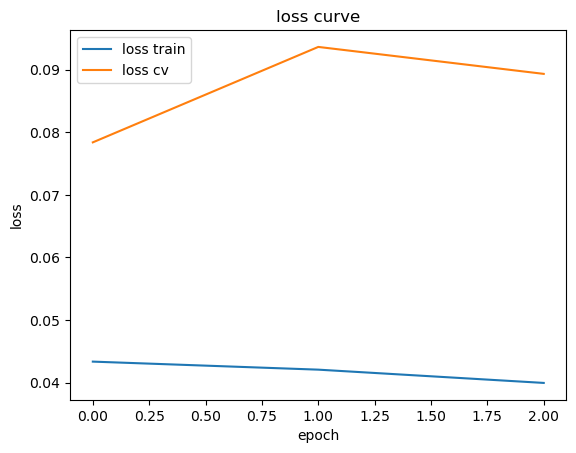

---------准确率accuracy随训练轮数epoch的变化图像---------


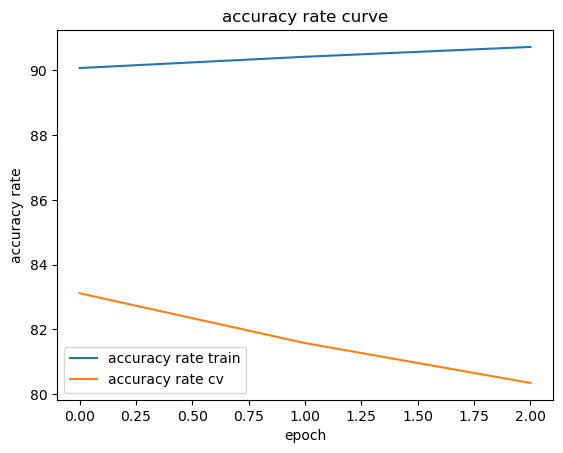

In [26]:
# 画出loss曲线
print("---------损失函数Loss随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), loss_train_store, np.arange(epoch), loss_cv_store)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss train", "loss cv"])
plt.title("loss curve")
plt.show()

# 画出accuracy曲线
print("---------准确率accuracy随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), accuracy_rate_train_store, np.arange(epoch), accuracy_rate_cv_store)
plt.xlabel("epoch")
plt.ylabel("accuracy rate")
plt.legend(["accuracy rate train", "accuracy rate cv"])
plt.title("accuracy rate curve")
plt.show()

In [7]:
# 加载某一轮训练的模型进行预测
# model = torch.load("model save/auto save/model auto save 14.pth")
model = torch.load("model save/history save/model save th1.05.pth")

# 开始使用神经网络预测
model.eval()
# 总测试次数
test_step = 0
# 统计准确性
right_0 = 0 # 同一个人识别为同一个人正确数
wrong_0 = 0 # 同一个人识别为不同人错误数
wrong_1 = 0 # 不同人识别为同一个人错误数
right_1 = 0 # 不同人识别为不同人正确数
# 记录距离
dis_pos_sum = 0.0
dis_neg_sum = 0.0
dis_pos_ave = 0.0
dis_neg_ave = 0.0

with torch.no_grad(): # 预测阶段不进行梯度下降
    for data in test_dataloader:
        # 获取图像
        img_anc, img_pos, img_neg = data
        # 将数据转换为cuda类型
        if torch.cuda.is_available():
            img_anc = img_anc.cuda()
            img_pos = img_pos.cuda()
            img_neg = img_neg.cuda()

        # 输入神经网络并运行
        output_anc, output_pos, output_neg = model(img_anc, img_pos, img_neg)

        # 计算两个的距离
        dis_pos = torch.nn.functional.pairwise_distance(output_anc, output_pos, p=2.0)
        dis_pos_sum += dis_pos.sum()
        dis_neg = torch.nn.functional.pairwise_distance(output_anc, output_neg, p=2.0)
        dis_neg_sum += dis_neg.sum()

        # 将距离与阈值比较
        dis_threshold_value = 1.05 # 可以选择重新调整距离阈值
        dis_threshold = torch.full([len(img_anc)], dis_threshold_value)
        # 将阈值转换为cuda类型
        if torch.cuda.is_available():
            dis_threshold = dis_threshold.cuda()
        wrong_0 += (dis_pos > dis_threshold).sum() # 同一个人识别为不同人错误数
        wrong_1 += (dis_neg <= dis_threshold).sum() # 不同人识别为同一个人错误数
        right_0 += (dis_pos <= dis_threshold).sum() # 同一个人识别为同一个人正确数
        right_1 += (dis_neg > dis_threshold).sum() # 不同人识别为不同人正确数
                        
        # 每10次输出结果
        if (test_step%30==0):
            print("同一个人的距离", dis_pos)
            print("不同人的距离", dis_neg)
                        
        test_step += len(img_anc)

dis_pos_ave = dis_pos_sum / test_step
print("平均同一个人距离", dis_pos_ave.item())
dis_neg_ave = dis_neg_sum / test_step
print("平均不同人距离", dis_neg_ave.item())

print("同一个人识别为同一个人正确数", right_0.item(),  "同一个人测试数量", test_step, "该类型正确率%.2f%%" %((right_0.item() / test_step) * 100))
print("同一个人识别为不同人错误数", wrong_0.item(), "同一个人测试数量", test_step, "该类型错误率%.2f%%" %((wrong_0.item() / test_step) * 100))
print("不同人识别为不同人正确数", right_1.item(),  "不同人测试数量", test_step, "该类型正确率%.2f%%" %((right_1.item() / test_step) * 100))
print("不同人识别为同一个人错误数", wrong_1.item(), "不同人测试数量", test_step, "该类型错误率%.2f%%" %((wrong_1.item() / test_step) * 100))

同一个人的距离 tensor([0.4452, 1.3231, 0.4092, 0.7197, 0.8280, 0.4954, 0.5340, 1.0448, 1.3107,
        0.4306, 0.5474, 0.7036, 0.6176, 1.1546, 0.4662, 0.3577, 0.9671, 0.7420,
        0.6497, 0.8406, 0.5290, 0.5251, 0.8010, 0.5463, 1.0619, 1.2092, 0.6716,
        1.0949, 0.7126, 0.6438, 0.3274, 0.5652, 0.4582, 0.6518, 1.0380, 1.3833,
        0.4019, 0.4887, 0.5769, 0.8854, 0.2880, 1.2233, 0.8494, 0.7719, 1.2513,
        0.9006, 0.9034, 1.1019, 1.4435, 0.5991, 0.5216, 0.6832, 0.2938, 0.7012,
        1.2746, 0.2186, 1.1941, 0.5900, 0.5607, 1.3678, 0.9831, 1.0050, 0.8936,
        0.8640], device='cuda:0')
不同人的距离 tensor([1.0683, 1.8536, 1.2648, 1.3498, 1.6012, 1.4800, 1.5553, 1.8313, 1.2067,
        1.3094, 1.3939, 1.3801, 1.5583, 1.8541, 0.6865, 1.6077, 1.4683, 1.4667,
        1.1716, 1.5024, 1.6702, 1.3733, 1.6933, 1.7041, 1.6126, 1.0708, 1.7161,
        1.5443, 1.1181, 0.8029, 1.5818, 1.1703, 1.5275, 1.4257, 1.4490, 1.4491,
        1.5876, 1.2272, 1.1610, 1.6355, 1.3853, 1.3360, 1.3024, 1.7073,

输入两张数据集中没有的人脸
输入图像


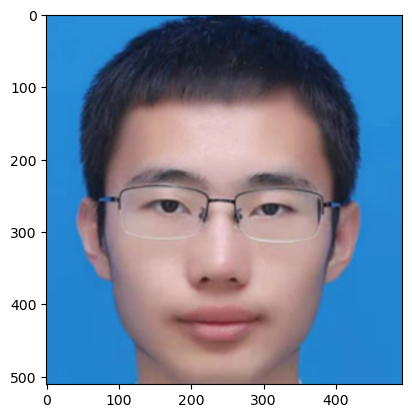

输入图像


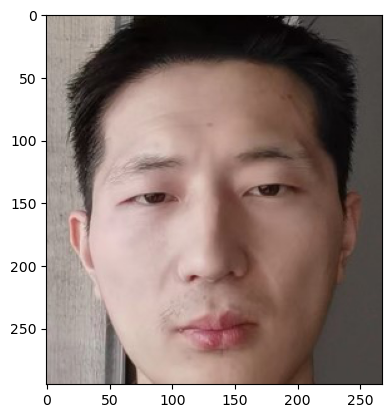

img1
tensor([[[[0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 0.1529,
           0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608,
           0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608,
           0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1569, 0.1608,
           0.1608, 0.1608, 0.1647, 0.1725, 0.1765, 0.1569, 0.1412, 0.1294,
           0.1020, 0.1137, 0.1059, 0.1294, 0.1412, 0.0824, 0.0627, 0.0510,
           0.0588, 0.0627, 0.0706, 0.0706, 0.0824, 0.0824, 0.1020, 0.1412,
           0.1451, 0.1176, 0.1137, 0.1412, 0.1490, 0.1608, 0.1529, 0.1490,
           0.1647, 0.1647, 0.1647, 0.1686, 0.1686, 0.1686, 0.1647, 0.1647,
           0.1647, 0.1686, 0.1686, 0.1647, 0.1647, 0.1647, 0.1608, 0.1608,
           0.1608, 0.1608, 0.1647, 0.1647, 0.1608, 0.1608, 0.1608, 0.1608,
           0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608, 0.1608,
           0.1608, 0.1608, 0.1608, 0.1608],
          [0.1529, 0.1529, 0.1529, 0.1529, 0.1529, 

In [26]:
# 加载某一轮训练的模型进行预测
# model = torch.load("model save/auto save/model auto save 8.pth")
model = torch.load("model save/history save/model save th1.05.pth")

# 加载外部数据进行推理
print("输入两张数据集中没有的人脸")

img_1_path = "dataset/image1.jpg"
img_2_path = "dataset/image4.jpg"

# 使用transform对图像进行压缩等变化
img_1 = Image.open(img_1_path) # torchvision必须使用PIL打开图片，不能直接使用plt的格式
plt.imshow(img_1)
print("输入图像")
plt.show()
img_2 = Image.open(img_2_path) # torchvision必须使用PIL打开图片，不能直接使用plt的格式
plt.imshow(img_2)
print("输入图像")
plt.show()

transform = torchvision.transforms.Compose([torchvision.transforms.Resize([100, 100]),
                                           torchvision.transforms.ToTensor()])
img_1 = transform(img_1)
img_2 = transform(img_2)
img_1 = torch.reshape(img_1, [1, 3, 100, 100])
img_2 = torch.reshape(img_2, [1, 3, 100, 100])
img_3 = torch.ones([1, 3, 100, 100]) # 为满足网络输入要求，使用全1数组代替img_3
# 将数据转换为cuda类型
if torch.cuda.is_available():
    img_1 = img_1.cuda()
    img_2 = img_2.cuda()
    img_3 = img_3.cuda()

# 打印输入的图像数组
torch.set_printoptions(threshold=np.inf) # 输出不打印省略号
print("img1")
print(img_1)
print("img2")
print(img_2)


# 开始使用神经网络预测
model.eval()
with torch.no_grad(): # 推理阶段不进行梯度下降
    # 输入进入神经网络进行预测
    output_1, output_2, output_3 = model(img_1, img_2, img_3)

# 输出结果
print("output_1 = ", output_1)
print("output_2 = ", output_2)
# 计算两个的距离
dis = torch.nn.functional.pairwise_distance(output_1, output_2, p=2.0)

# 将距离与阈值比较
dis_threshold_value = 1.05 # 可以选择重新调整距离阈值
if(dis <= dis_threshold_value):
    pred_label = 0
else:
    pred_label = 1

# 将距离转化为可能性
dis_max = 3
probability = 1 - (dis / dis_max)
probability_threshold_value = 1 - (dis_threshold_value / dis_max)

# 查看原始数据并显示
print("相似度: %.2f %%" %(probability.item()*100))
print("相似度阈值:  %.2f %%" %(probability_threshold_value*100))

print("距离：  %.5f" %dis.item())
print("距离阈值： %.2f" %dis_threshold_value)

label_list = ["0同一个人", "1不同人"]
print("模型预测结果是:", label_list[pred_label])

In [33]:
# 保存神经网络模型
# torch.save(model, "model save/history save/model save th.pth")
print("模型已保存")

模型已保存


In [25]:
# 查看网络参数
torch.set_printoptions(threshold=np.inf) # 输出不打印省略号
print(model)

model.named_parameters()
for name, param in model.named_parameters(prefix="SiameseNet"):
    print(name, param)
    print(name, param.size())

# print(net_AlexNet.state_dict().keys())
# print(net_AlexNet.state_dict())

SiameseNet(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=144, out_features=128, bias=True)
  )
)
SiameseNet.model.0.weight Parameter containing:
tensor([[[[-7.7584e-02, -1.2937e-01, -2.8528e-02,  4.0689e-03,  9.0782e-02],
          [-1.4067e-01, -8.2078e-02, -1.6123e-02, -5.0237e-02,  6.1417e-02],
          [-3.5628e-02, -8.5116e-02,  5.7338e-02, -9.0203e-02,  1.0322e-01],
     

In [21]:
# 清除显存
torch.cuda.empty_cache()